##Melissa Feeney
###May 2022

## **Can Deep Learning be used to correctly identify X-Rays of patients with COVID-19 and viral pneumonia?**

## ***Four different Convolutional Neural Network (CNN) models were tested for this classification task, all varying in architectures***


## **Setup**

In [3]:
# Load libraries and then download data
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

from sklearn.metrics import classification_report


In [4]:
# Extracting all filenames iteratively
%%capture
base_path = 'COVID-19 Radiography Database'
categories = ['COVID', 'NORMAL', 'Viral Pneumonia']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

## **Preprocessor Function**

In [5]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.  

        # Resize the images.
        X = np.array(img)
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X


In [6]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [8]:
print(len(X) ) # same number of elements as filenames
print(X.shape ) # dimensions now 192,192,3 for all images
print(X.min() ) # min value of every image is zero
print(X.max() ) # max value of every image is one


3886
(3886, 192, 192, 3)
0.0
1.0


In [9]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1200))
normal=list(repeat("NORMAL", 1341))
pneumonia=list(repeat("PNEUMONIA", 1345))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1200, 1341, 1345]
3886


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
3881,0,0,1
3882,0,0,1
3883,0,0,1
3884,0,0,1


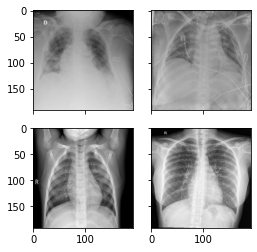

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor('COVID-19 Radiography Database/COVID/COVID (100).png')
im2 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1024).png')
im3 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1000).png')
im4 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1031).png')

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

In [11]:
# ======Train test split resized images=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)


y_test.sum()

COVID        240
NORMAL       269
PNEUMONIA    269
dtype: int64

## **Save Preprocessor**


In [12]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


## **X-Ray Visualizations**
*Visualizing X-Ray images that demonstrate Covid Postivity and when they do not*


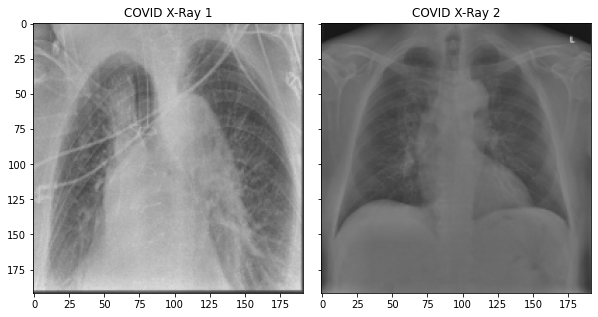

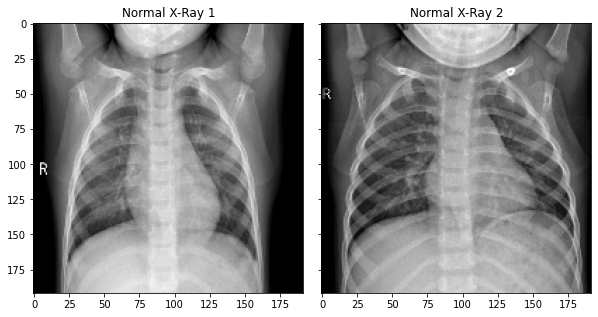

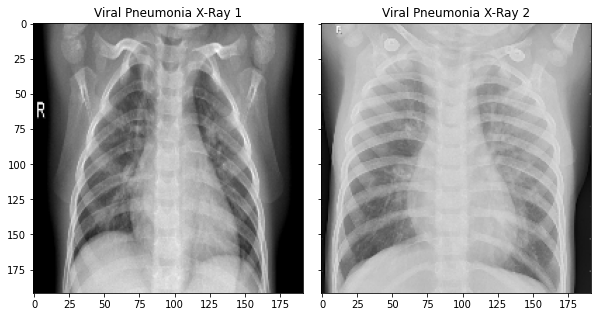

In [13]:
# Visualizing the different conditions
covid_1 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1000).png')
covid_2 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1001).png')

normal_1 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1000).png')
normal_2 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1001).png')

vpn_1 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1000).png')
vpn_2 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1001).png')

# COVID X-Rays
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [covid_1, covid_2]):  
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    grid.axes_all[0].set_title('COVID X-Ray 1')
    grid.axes_all[1].set_title('COVID X-Ray 2')

plt.show()


# Normal X-Rays
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [normal_1, normal_2]):  
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    grid.axes_all[0].set_title('Normal X-Ray 1')
    grid.axes_all[1].set_title('Normal X-Ray 2')

plt.show()


# Viral Pneumonia X-Rays
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [vpn_1, vpn_2]):  
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    grid.axes_all[0].set_title('Viral Pneumonia X-Ray 1')
    grid.axes_all[1].set_title('Viral Pneumonia X-Ray 2')

plt.show()


# **Prediction Models**


## **Model 1- No Batch Normalization**


In [16]:
# Model 1- No batch normalization
import tensorflow as tf
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=2, filters=128, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),

    tf.keras.layers.Conv2D(kernel_size=2, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),

    tf.keras.layers.Conv2D(kernel_size=2, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),

    tf.keras.layers.Conv2D(kernel_size=2, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1,mode='max') 

  model1.compile(
    optimizer=Adam(lr=0.001), 
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model1.fit(X_train, y_train, 
                    epochs = 50, verbose=1,validation_data=(X_test,y_test), callbacks=[red_lr]) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
98/98 [==============================] - 17s 61ms/step - loss: 0.5607 - accuracy: 0.7606 - val_loss: 0.2856 - val_accuracy: 0.8920 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 5s 55ms/step - loss: 0.2330 - accuracy: 0.9147 - val_loss: 0.1914 - val_accuracy: 0.9203 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 5s 55ms/step - loss: 0.1569 - accuracy: 0.9476 - val_loss: 0.1037 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 5s 55ms/step - loss: 0.1214 - accuracy: 0.9579 - val_loss: 0.0992 - val_accuracy: 0.9666 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 5s 56ms/step - loss: 0.1131 - accuracy: 0.9598 - val_loss: 0.0850 - val_accuracy: 0.9679 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 5s 55ms/step - loss: 0.0898 - accuracy: 0.9656 - val_loss: 0.0923 - val_accuracy: 0.9717 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 5s 55ms/step - loss: 0.

## **Model 2- With Batch Normalization**

In [18]:
# Model 2- With batch normalization
import tensorflow as tf
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=2, filters=128, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(kernel_size=2, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(kernel_size=2, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(kernel_size=2, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1) 

  model2.compile(
    optimizer=Adam(lr=0.001), 
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model2.fit(X_train, y_train, 
                    epochs = 50, verbose=1,validation_data=(X_test,y_test), callbacks=[red_lr]) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
98/98 [==============================] - 7s 62ms/step - loss: 0.2329 - accuracy: 0.9112 - val_loss: 2.8827 - val_accuracy: 0.3458 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 6s 58ms/step - loss: 0.1116 - accuracy: 0.9665 - val_loss: 5.0089 - val_accuracy: 0.3085 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 6s 57ms/step - loss: 0.0958 - accuracy: 0.9688 - val_loss: 2.3052 - val_accuracy: 0.5463 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 6s 57ms/step - loss: 0.0457 - accuracy: 0.9852 - val_loss: 2.1583 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 6s 57ms/step - loss: 0.0225 - accuracy: 0.9916 - val_loss: 4.5091 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 6s 57ms/step - loss: 0.0261 - accuracy: 0.9900 - val_loss: 0.4175 - val_accuracy: 0.8753 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 6s 57ms/step - loss: 0.0

## **Model 3- With Batch Normalization and Dropout Layers**

In [19]:
# Model 3- With Batch Normlization and Dropout Layer
import tensorflow as tf
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=2, filters=128, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.8),

    tf.keras.layers.Conv2D(kernel_size=2, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(kernel_size=2, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(kernel_size=2, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1) 

  model3.compile(
    optimizer=Adam(lr=0.001), 
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model3.fit(X_train, y_train, 
                    epochs = 50, verbose=1,validation_data=(X_test,y_test), callbacks=[red_lr]) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
98/98 [==============================] - 7s 68ms/step - loss: 0.2733 - accuracy: 0.8929 - val_loss: 5.3942 - val_accuracy: 0.3085 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 6s 62ms/step - loss: 0.1338 - accuracy: 0.9540 - val_loss: 13.5051 - val_accuracy: 0.3085 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 6s 62ms/step - loss: 0.1223 - accuracy: 0.9562 - val_loss: 9.8628 - val_accuracy: 0.3226 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 6s 62ms/step - loss: 0.0749 - accuracy: 0.9733 - val_loss: 7.6292 - val_accuracy: 0.5373 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 6s 62ms/step - loss: 0.0743 - accuracy: 0.9727 - val_loss: 5.6269 - val_accuracy: 0.5578 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 6s 62ms/step - loss: 0.0551 - accuracy: 0.9804 - val_loss: 3.8126 - val_accuracy: 0.5977 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 6s 62ms/step - loss: 0.

## **Model 4- CheXNet Transfer Learning**


*I was curious if there were any models trained on X-Ray images that I could use for transfer learning- and found CheXNet! It is built on DenseNet121. Here are some of the resources I found, including the [GitHub page](https://github.com/brucechou1983/CheXNet-Keras) from which the weights are extracted.*


In [66]:
# Model 4- CheXNet Transfer Learning
import tensorflow as tf
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

from tensorflow.keras.applications import densenet
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense


# Path to the pretrained weights
chexnet_weights_path = 'brucechou1983_CheXNet_Keras_0.3.0_weights.h5'


# # Instantiate CheXnet model with pretrained weights. Pop last layers, add average pooling
base = densenet.DenseNet121(weights=None,
                                include_top=False,
                                input_shape=(192,192,3))

# The initial CheXNet model was trained on X-Rays to detect 14 different conditions
predictions = tf.keras.layers.Dense(14, activation='sigmoid', name='predictions')(base.output) # the base model used sigmoid activation because the classifications was not mutually exclusive
base = tf.keras.Model(inputs=base.input, outputs=predictions) 

# Load the pretrained weights
base.load_weights(chexnet_weights_path)
print("CheXNet loaded!")

new_model = tf.keras.layers.GlobalAveragePooling2D()(base.layers[-1].output) 
new_model = tf.keras.layers.Dense(3, activation='softmax')(new_model) # change to softmax output because these classifications are mutually exclusive

model4 = tf.keras.Model(base.input, new_model)

from tensorflow.python.keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1,mode='max') 

model4.compile(
    optimizer=Adam(lr=0.001), 
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
# Fitting the CNN to the Training set
model4.fit(X_train, y_train, 
                    epochs = 50, verbose=1,validation_data=(X_test,y_test), callbacks=[red_lr]) 


CheXNet loaded!


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
98/98 [==============================] - 73s 176ms/step - loss: 0.9033 - accuracy: 0.6802 - val_loss: 0.7689 - val_accuracy: 0.7121 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 15s 157ms/step - loss: 0.4740 - accuracy: 0.9627 - val_loss: 0.9573 - val_accuracy: 0.6350 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 15s 157ms/step - loss: 0.2559 - accuracy: 0.9768 - val_loss: 0.3593 - val_accuracy: 0.9036 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 15s 158ms/step - loss: 0.1636 - accuracy: 0.9807 - val_loss: 0.1454 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 16s 160ms/step - loss: 0.1055 - accuracy: 0.9897 - val_loss: 0.6376 - val_accuracy: 0.7185 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 15s 158ms/step - loss: 0.0907 - accuracy: 0.9903 - val_loss: 0.2801 - val_accuracy: 0.8985 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - ETA: 0s - lo

## **Evaluating Each Model on the Test Set Data**

In [68]:
# Test set accuracy and loss
model1_score = model1.evaluate(X_test, y_test) 
model2_score = model2.evaluate(X_test, y_test) 
model3_score = model3.evaluate(X_test, y_test) 
model4_score = model4.evaluate(X_test, y_test) 

models = pd.DataFrame(['model 1', 'model 2', 'model 3', 'model 4'])
scores = pd.DataFrame([model1_score, model2_score, model3_score, model4_score])
results = pd.concat([models, scores], axis = 1)
results.columns = ['Model', 'Test Set Loss', 'Test Set Accuracy']
results


25/25 [==============================] - 1s 48ms/step - loss: 0.0670 - accuracy: 0.9871


,Model,Test Set Loss,Test Set Accuracy
0,model 1,0.071186,0.978149
1,model 2,0.092738,0.971722
2,model 3,2.376859,0.717224
3,model 4,0.067038,0.987147


In [71]:
# Predictions by model
def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype('int32')

model1_prediction_index = predict_classes(model1.predict(X_test))
model2_prediction_index = predict_classes(model2.predict(X_test))
model3_prediction_index = predict_classes(model3.predict(X_test))
model4_prediction_index = predict_classes(model4.predict(X_test))

# get labels from one hot encoded y_train data
labels = pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method
model1_prediction_labels = list(map(lambda x: labels[x], model1_prediction_index))
model2_prediction_labels = list(map(lambda x: labels[x], model2_prediction_index))
model3_prediction_labels = list(map(lambda x: labels[x], model3_prediction_index))
model4_prediction_labels = list(map(lambda x: labels[x], model4_prediction_index))


In [72]:
# Classification Reports
y_pred_1 = pd.get_dummies(model1_prediction_labels)
y_pred_2 = pd.get_dummies(model2_prediction_labels)
y_pred_3 = pd.get_dummies(model3_prediction_labels)
y_pred_4 = pd.get_dummies(model4_prediction_labels)

print('Model 1 Classification Report')
print(classification_report(y_test, y_pred_1, target_names = ['COVID-19', 'Normal', 'Pneumonia']))
print(' ')

print('Model 2 Classification Report')
print(classification_report(y_test, y_pred_2, target_names = ['COVID-19', 'Normal', 'Pneumonia']))
print(' ')

print('Model 3 Classification Report')
print(classification_report(y_test, y_pred_3, target_names = ['COVID-19', 'Normal', 'Pneumonia']))
print(' ')

print('Model 4 Classification Report')
print(classification_report(y_test, y_pred_4, target_names = ['COVID-19', 'Normal', 'Pneumonia']))


Model 1 Classification Report
              precision    recall  f1-score   support

    COVID-19       0.98      0.98      0.98       240
      Normal       0.98      0.99      0.98       269
   Pneumonia       0.98      0.96      0.97       269

   micro avg       0.98      0.98      0.98       778
   macro avg       0.98      0.98      0.98       778
weighted avg       0.98      0.98      0.98       778
 samples avg       0.98      0.98      0.98       778

 
Model 2 Classification Report
              precision    recall  f1-score   support

    COVID-19       0.98      0.98      0.98       240
      Normal       0.97      0.97      0.97       269
   Pneumonia       0.96      0.96      0.96       269

   micro avg       0.97      0.97      0.97       778
   macro avg       0.97      0.97      0.97       778
weighted avg       0.97      0.97      0.97       778
 samples avg       0.97      0.97      0.97       778

 
Model 3 Classification Report
              precision    recall  f